In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import  AutoModelForSequenceClassification, AutoTokenizer
import os
import wandb
os.environ["WANDB_LOG_MODEL"] = "checkpoint" 

/home/nightstalker/miniconda3/envs/pytorch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
wandb.init(
    # set the wandb project where this run will be logged
    project="impossible-querry-pipeline",
    # track hyperparameters and run metadata
    name="gemini-distilbert"
)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: mehdinejjar (mehdinejjar-al-akhawayn-university). Use `wandb login --relogin` to force relogin


In [3]:
df = pd.read_csv("../dataset/dataset-match-score.csv")
df['text'] = df['text'].apply(lambda x: x.replace('\n', ' ').replace('*', ''))

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1416 entries, 0 to 1415
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1416 non-null   object
 1   labels  1416 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 22.3+ KB


In [5]:
# count the count of unique labels
df['labels'].value_counts()

labels
1    589
0    424
2    403
Name: count, dtype: int64

In [6]:
checkpoint = "distilbert-base-cased" # Define which pre-trained model we will be using
classifier = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3) # Get the classifier
tokenizer = AutoTokenizer.from_pretrained(checkpoint) # Get the tokenizer

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/nightstalker/miniconda3/envs/pytorch/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
df_train, df_eval = train_test_split(df, train_size=0.8, stratify=df.labels, random_state=42) # Stratified splitting

In [8]:
from datasets import Dataset, DatasetDict
raw_datasets = DatasetDict({
    "train": Dataset.from_pandas(df_train),
    "eval": Dataset.from_pandas(df_eval)
})

In [9]:
# Check the datasets
print("Dataset Dict:\n", raw_datasets)
print("\n\nTrain's features:\n", raw_datasets["train"].features)
print("\n\nFirst row of Train:\n", raw_datasets["train"][0])

Dataset Dict:
 DatasetDict({
    train: Dataset({
        features: ['text', 'labels', '__index_level_0__'],
        num_rows: 1132
    })
    eval: Dataset({
        features: ['text', 'labels', '__index_level_0__'],
        num_rows: 284
    })
})


Train's features:
 {'text': Value(dtype='string', id=None), 'labels': Value(dtype='int64', id=None), '__index_level_0__': Value(dtype='int64', id=None)}


First row of Train:
 {'text': 'Question: Does the basic fitness app with limited tracking features and no social integration, as seen in the document and row, meet user expectations? Answer: It offers minimal tracking functionality; Therefore, the match score is 10', 'labels': 1, '__index_level_0__': 891}


In [10]:
# Tokenize the text, and truncate the text if it exceed the tokenizer maximum length. Batched=True to tokenize multiple texts at the same time.
tokenized_datasets = raw_datasets.map(lambda dataset: tokenizer(dataset['text'], truncation=True), batched=True)
print(tokenized_datasets)

Map:   0%|          | 0/1132 [00:00<?, ? examples/s]

Map: 100%|██████████| 284/284 [00:00<00:00, 24451.06 examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 1132
    })
    eval: Dataset({
        features: ['text', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 284
    })
})


In [11]:
print(tokenized_datasets["train"][0])

{'text': 'Question: Does the basic fitness app with limited tracking features and no social integration, as seen in the document and row, meet user expectations? Answer: It offers minimal tracking functionality; Therefore, the match score is 10', 'labels': 1, '__index_level_0__': 891, 'input_ids': [101, 22171, 131, 7187, 1103, 3501, 12691, 12647, 1114, 2609, 10066, 1956, 1105, 1185, 1934, 9111, 117, 1112, 1562, 1107, 1103, 5830, 1105, 5105, 117, 2283, 4795, 11471, 136, 26018, 131, 1135, 3272, 10298, 10066, 16354, 132, 6589, 117, 1103, 1801, 2794, 1110, 1275, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [12]:
tokenized_datasets = tokenized_datasets.remove_columns(["text", "__index_level_0__"])
print(tokenized_datasets)

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 1132
    })
    eval: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 284
    })
})


In [13]:
from transformers import DataCollatorWithPadding, TrainingArguments, Trainer
import numpy as np
import evaluate
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Padding for batch of data that will be fed into model for training
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Training args 
training_args = TrainingArguments("train-checkpoints-epoch", 
                                  num_train_epochs=5, 
                                  evaluation_strategy="steps", 
                                  weight_decay=5e-4, 
                                  per_device_train_batch_size=64,
                                  per_device_eval_batch_size=64,
                                  save_strategy="steps",
                                  # fp16=True,
                                  load_best_model_at_end=True,
                                  report_to="wandb",)

# Metric for validation error
def compute_metrics(pred):
    """
    Computes accuracy, F1, precision, and recall for a given set of predictions.

    Args:
        pred (obj): An object containing label_ids and predictions attributes.
            - label_ids (array-like): A 1D array of true class labels.
            - predictions (array-like): A 2D array where each row represents
              an observation, and each column represents the probability of
              that observation belonging to a certain class.

    Returns:
        dict: A dictionary containing the following metrics:
            - Accuracy (float): The proportion of correctly classified instances.
            - F1 (float): The macro F1 score, which is the harmonic mean of precision
              and recall. Macro averaging calculates the metric independently for
              each class and then takes the average.
            - Precision (float): The macro precision, which is the number of true
              positives divided by the sum of true positives and false positives.
            - Recall (float): The macro recall, which is the number of true positives
              divided by the sum of true positives and false negatives.
    """
    # Extract true labels from the input object
    labels = pred.label_ids

    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)

    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')

    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

# Define trainer
trainer = Trainer(
    classifier,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["eval"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/home/nightstalker/miniconda3/envs/pytorch/lib/python3.11/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [14]:
# Start the fine-tuning 
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
100%|██████████| 90/90 [00:22<00:00,  5.13it/s]

{'train_runtime': 22.4518, 'train_samples_per_second': 252.096, 'train_steps_per_second': 4.009, 'train_loss': 0.13777036666870118, 'epoch': 5.0}


100%|██████████| 90/90 [00:23<00:00,  3.80it/s]


TrainOutput(global_step=90, training_loss=0.13777036666870118, metrics={'train_runtime': 22.4518, 'train_samples_per_second': 252.096, 'train_steps_per_second': 4.009, 'total_flos': 92040610911480.0, 'train_loss': 0.13777036666870118, 'epoch': 5.0})

In [15]:
trainer.save_model("train-checkpoints-step/best-model/")

In [16]:
from sklearn.metrics import classification_report

# Make prediction on evaluation dataset
y_pred = trainer.predict(tokenized_datasets["eval"]).predictions
y_pred = np.argmax(y_pred, axis=-1)

# Get the true labels
y_true = tokenized_datasets["eval"]["labels"]
y_true = np.array(y_true)

# Print the classification report
print(classification_report(y_true, y_pred, digits=4))

100%|██████████| 5/5 [00:00<00:00, 20.22it/s]

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        85
           1     1.0000    1.0000    1.0000       118
           2     1.0000    1.0000    1.0000        81

    accuracy                         1.0000       284
   macro avg     1.0000    1.0000    1.0000       284
weighted avg     1.0000    1.0000    1.0000       284



In [17]:
y_true, y_pred

(array([1, 0, 0, 0, 0, 1, 0, 2, 0, 1, 1, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 1,
        0, 2, 1, 2, 2, 2, 0, 0, 0, 2, 1, 2, 2, 1, 2, 2, 0, 1, 0, 2, 1, 1,
        1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 2, 0, 1, 0,
        1, 0, 2, 1, 2, 1, 2, 2, 2, 0, 2, 1, 1, 1, 0, 1, 2, 1, 0, 1, 2, 0,
        1, 1, 1, 1, 2, 0, 2, 1, 1, 0, 2, 2, 1, 2, 1, 2, 2, 2, 0, 0, 2, 0,
        1, 2, 1, 1, 0, 2, 0, 0, 1, 2, 0, 1, 0, 2, 1, 2, 1, 1, 1, 1, 1, 2,
        0, 0, 2, 1, 2, 1, 0, 1, 1, 1, 0, 2, 1, 0, 2, 1, 1, 1, 1, 1, 2, 1,
        1, 2, 2, 0, 1, 1, 2, 1, 0, 0, 1, 0, 1, 1, 0, 1, 2, 1, 1, 1, 0, 0,
        2, 2, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 2, 1, 2, 0, 1, 0, 1, 2, 1, 1,
        2, 2, 2, 1, 0, 0, 2, 0, 0, 2, 1, 1, 1, 0, 2, 2, 0, 0, 0, 1, 2, 1,
        1, 0, 1, 1, 0, 1, 2, 0, 2, 1, 0, 2, 1, 2, 0, 2, 2, 1, 1, 1, 2, 0,
        2, 1, 0, 1, 1, 1, 1, 2, 2, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1,
        1, 0, 1, 1, 0, 2, 0, 2, 2, 0, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2]),
 array([1, 0, 0, 0, 0, 1, 0, 2, 0, 1, 1, 2

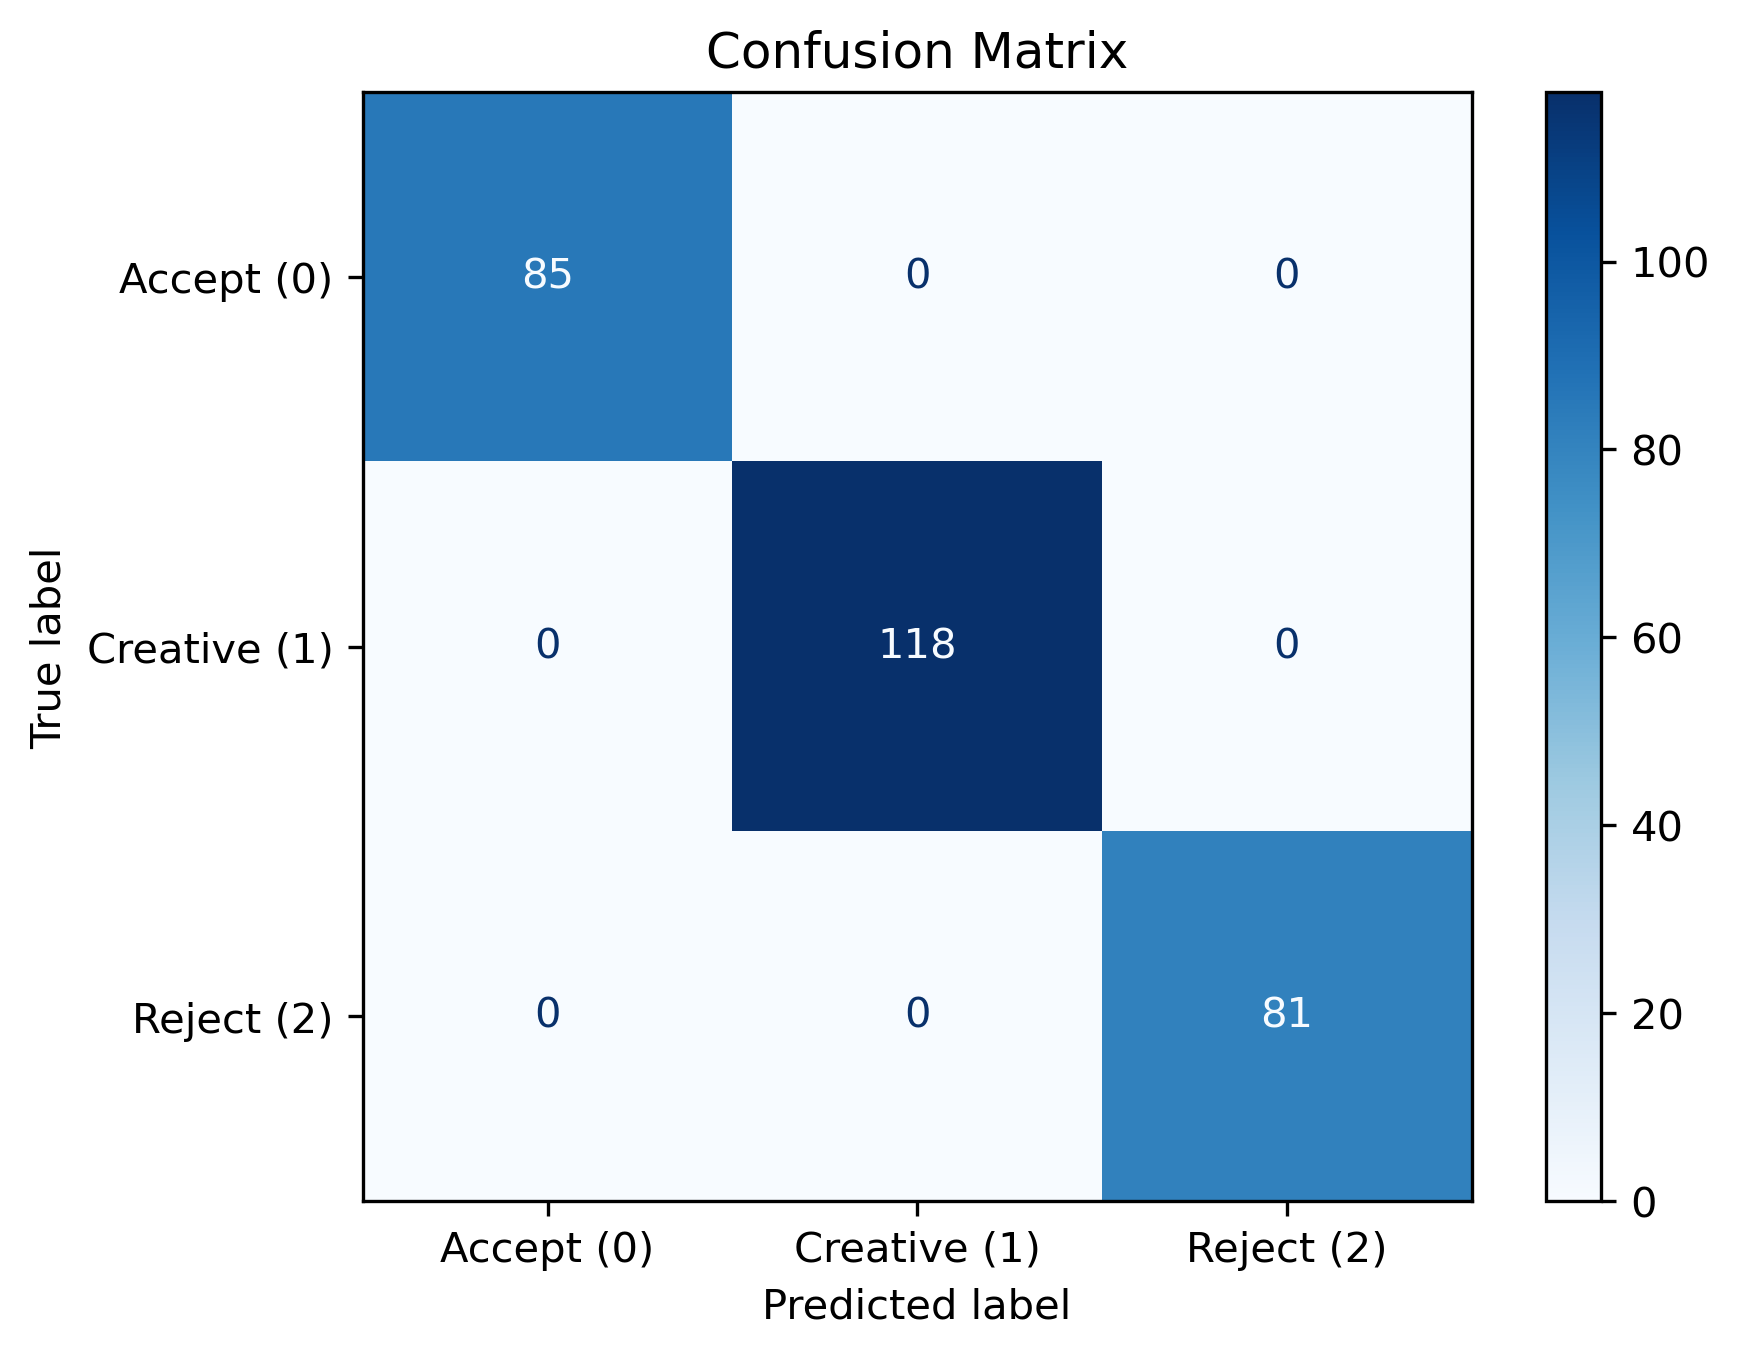

In [18]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Accept (0)", "Creative (1)", "Reject (2)"])

# Plot confusion matrix
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()